<a href="https://colab.research.google.com/github/LEESUSUSUSU/Credit-card-fraud-detection-model/blob/main/%EC%B9%B4%EB%93%9C%EC%82%AC%EA%B8%B02_%EC%9B%90%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
#imblearn 불균형한 데이터 셋을 맞추기 위함
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline #
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# ROC 곡선 시각화 함수 정의
def plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr):
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_reg_pred_prob):.3f})')
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {roc_auc_score(y_test, cnn_pred_prob):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

from sklearn.metrics import auc

def plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(10, 8))

    # 각 모델의 AUC 계산 및 플롯
    models_fpr_tpr = [
        (log_reg_fpr, log_reg_tpr, 'Logistic Regression'),
        (cnn_fpr, cnn_tpr, 'CNN'),
        (knear_fpr, knear_tpr, 'K-Nearest Neighbors'),
        (svc_fpr, svc_tpr, 'Support Vector Machine'),
        (tree_fpr, tree_tpr, 'Decision Tree')
    ]

    for fpr, tpr, label in models_fpr_tpr:
        model_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {model_auc:.2f})')

    # 기준선
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # 축과 제목 설정
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple Classifiers')
    plt.legend(loc='lower right')

    # 그래프 표시
    plt.show()




In [ ]:
df=pd.read_csv('/content/drive/MyDrive/신용_ML/data/creditcard.csv') # 유럽
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.isnull().sum().max()

0

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


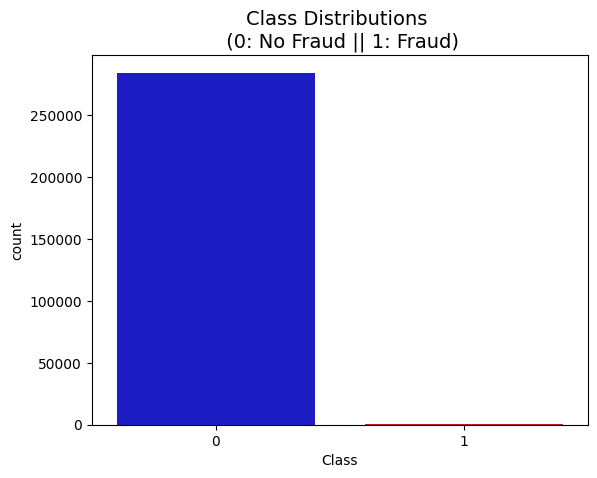

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

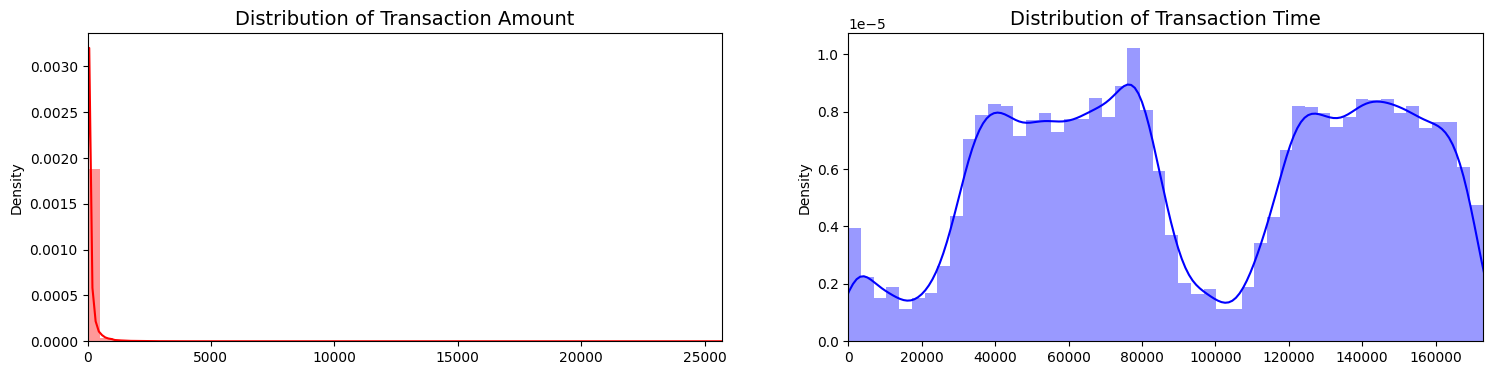

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

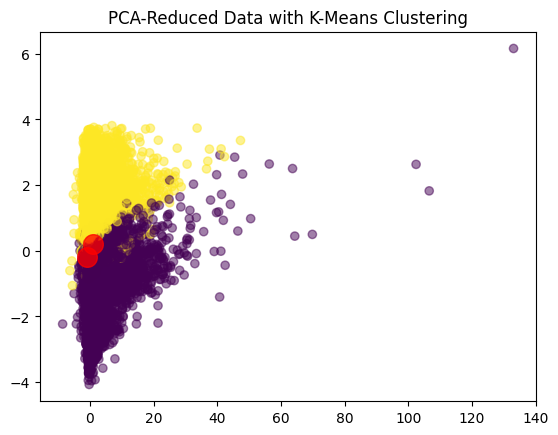

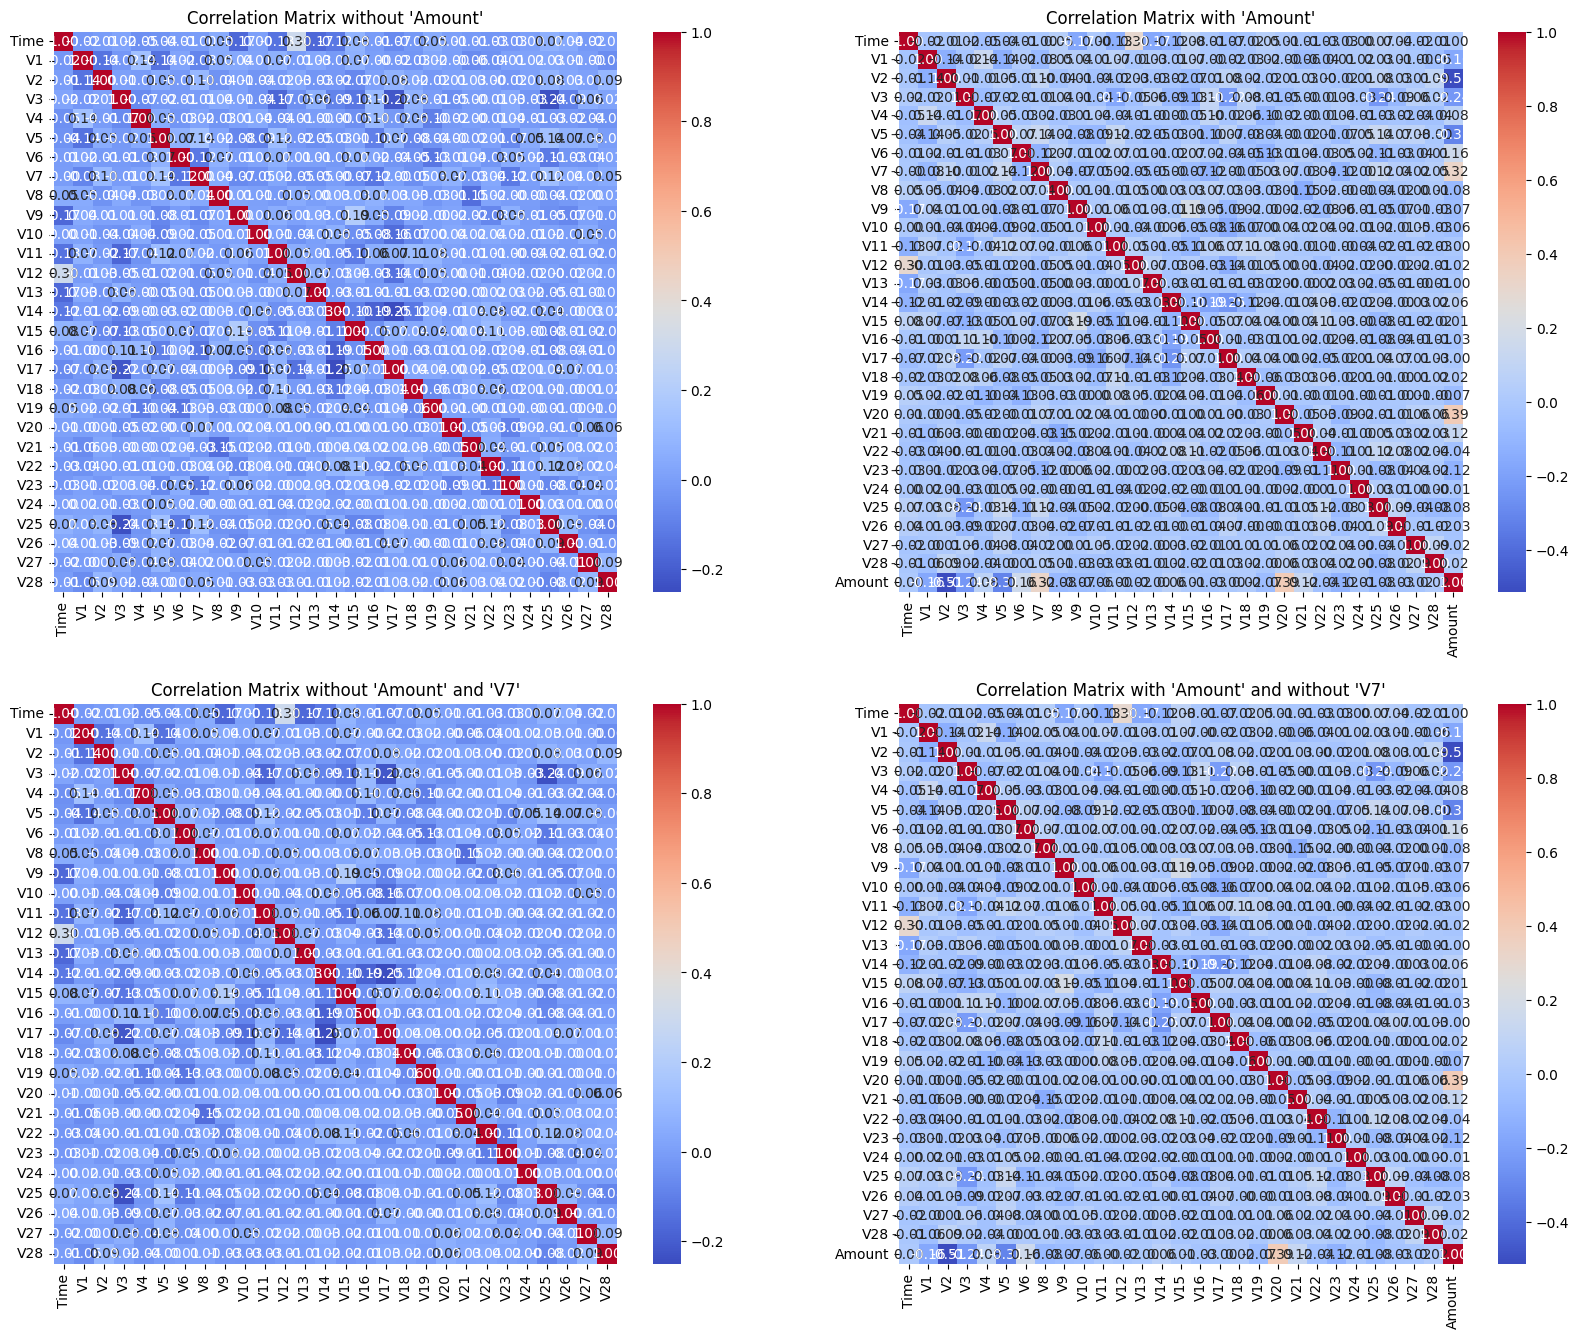

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

u_copy = df

features = u_copy.drop(['Class'], axis=1)


#정규화

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#k-평균

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features_scaled)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

pca =PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.title("PCA-Reduced Data with K-Means Clustering")
plt.show()


# 클러스터 레이블 할당
u_copy['Cluster'] = kmeans.labels_


# 특정 클러스터 (예: 레이블 1인 클러스터)의 데이터 추출
cluster_data = u_copy[u_copy['Cluster'] == 1]




cluster_data

correlation_matrix1 = cluster_data.drop([ 'Class', 'Cluster', 'Amount'], axis=1).corr()
correlation_matrix2 = cluster_data.drop([ 'Class', 'Cluster'], axis=1).corr()
correlation_matrix3 = cluster_data.drop([ 'Class', 'Cluster', 'Amount', 'V7'], axis=1).corr()
correlation_matrix4 = cluster_data.drop(['Class', 'Cluster', 'V7'], axis=1).corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))  # Adjusted size to better fit four plots

# Heatmap 1: Without 'Amount'
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.heatmap(correlation_matrix1, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix without 'Amount'")

# Heatmap 2: With 'Amount'
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.heatmap(correlation_matrix2, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix with 'Amount'")

# Heatmap 3: Without 'Amount' and 'V7'
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
sns.heatmap(correlation_matrix3, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix without 'Amount' and 'V7'")

# Heatmap 4: With 'Amount' and without 'V7'
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
sns.heatmap(correlation_matrix4, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix with 'Amount' and without 'V7'")

# Show the plot
plt.show()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 32)            128       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 15, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 448)               0   

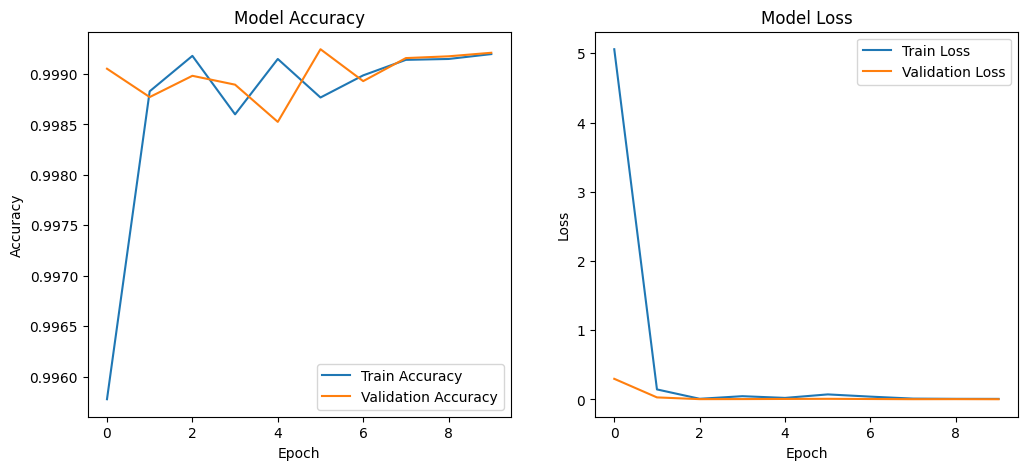

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

# Set seed for NumPy and TensorFlow to ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Assuming 'new_df' is your DataFrame and it's already loaded with the correct data
X = df.drop(['Class', 'Cluster'], axis=1)  # 'Class'와 'Cluster' 컬럼을 제외한 나머지를 사용
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape the data for CNN input
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)

# Define the CNN model architecture
input_shape = (X_train.shape[1], 1)  # Shape of input data
inputs = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Compile the CNN model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1781/1781 [==============================] - 3s 1ms/step


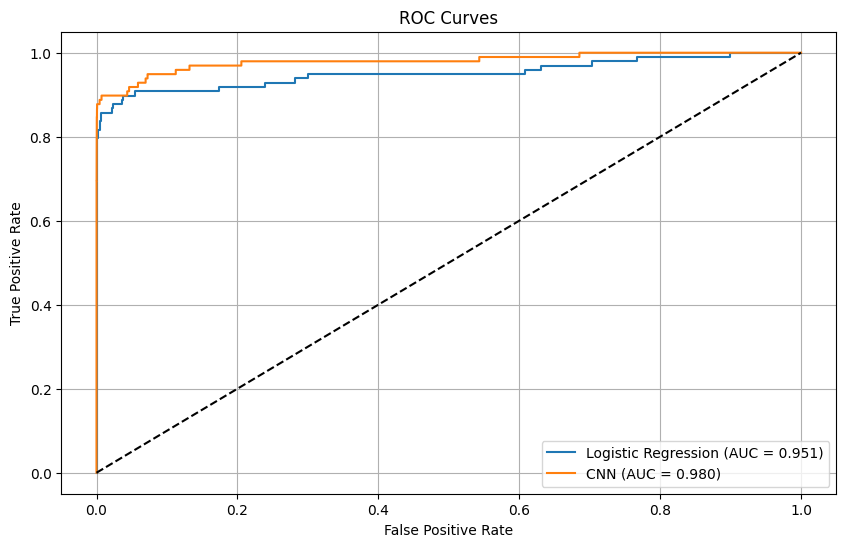

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 데이터를 2차원으로 변환
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Logistic Regression 모델 훈련 및 예측
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_2d, y_train)
log_reg_pred_prob = log_reg.predict_proba(X_test_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_prob)

# CNN 모델의 예측 확률 계산 및 ROC 곡선 구성
cnn_pred_prob = model.predict(X_test).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred_prob)



# ROC 곡선 시각화 함수 정의
def plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr):
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_reg_pred_prob):.3f})')
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {roc_auc_score(y_test, cnn_pred_prob):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# ROC 곡선 그리기
plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr)




In [ ]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Cluster
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 30, 32)            128       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 15, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 448)               0   

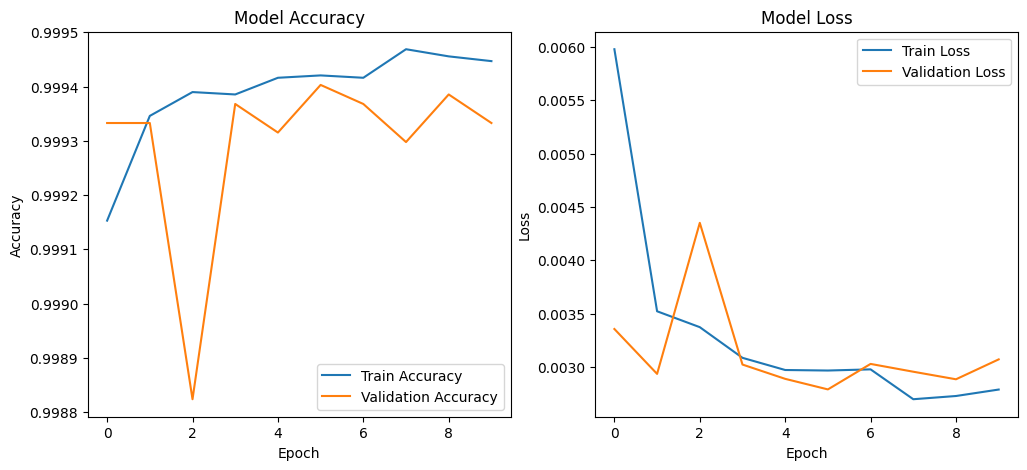

In [ ]:
# Set seed for NumPy and TensorFlow to ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Assuming 'new_df' is your DataFrame and it's already loaded with the correct data
X = df.drop(['Class', 'Cluster'], axis=1)  # 'Class'와 'Cluster' 컬럼을 제외한 나머지를 사용
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape the data for CNN input
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)

# Define the CNN model architecture
input_shape = (X_train.shape[1], 1)  # Shape of input data
inputs = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Compile the CNN model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1781/1781 [==============================] - 3s 1ms/step


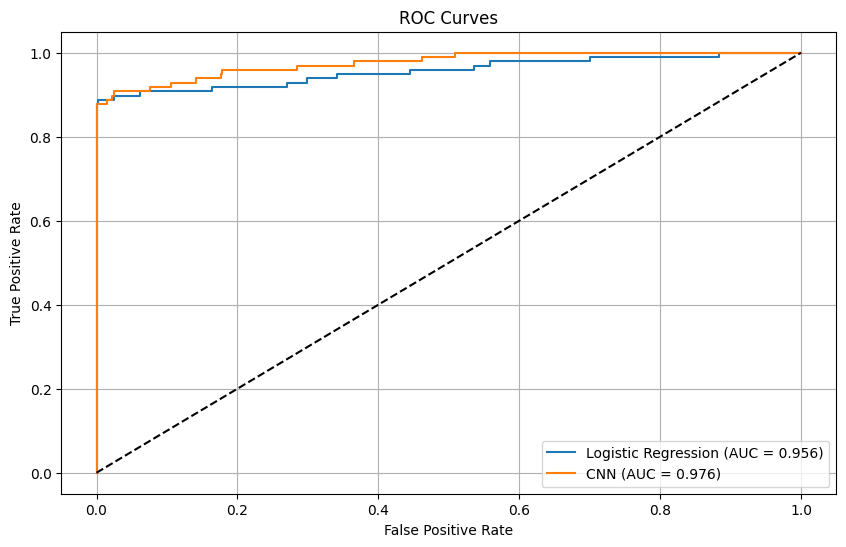

In [ ]:


# 데이터를 2차원으로 변환
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Logistic Regression 모델 훈련 및 예측
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_2d, y_train)
log_reg_pred_prob = log_reg.predict_proba(X_test_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_prob)

# CNN 모델의 예측 확률 계산 및 ROC 곡선 구성
cnn_pred_prob = model.predict(X_test).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred_prob)


# ROC 곡선 시각화 함수 정의
def plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr):
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_reg_pred_prob):.3f})')
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {roc_auc_score(y_test, cnn_pred_prob):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# ROC 곡선 그리기
plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr)

# # ROC 곡선 시각화
# plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop(['Class', 'Cluster'], axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 30, 32)            128       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 15, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 448)               0   

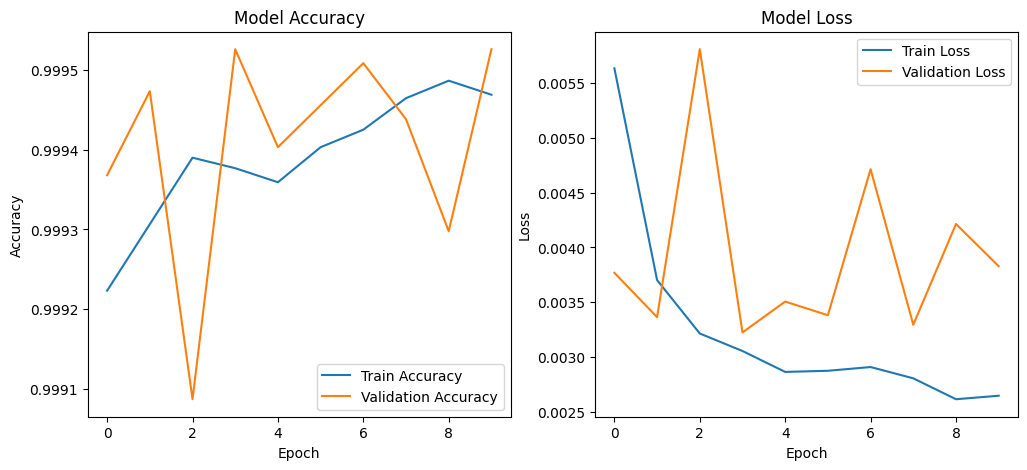

In [ ]:

# Reshape the data for CNN input
original_Xtrain = np.expand_dims(original_Xtrain, axis=2)
original_Xtest = np.expand_dims(original_Xtest, axis=2)

# Define the CNN model architecture
input_shape = (original_Xtrain.shape[1], 1)  # Shape of input data
inputs = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Compile the CNN model
model1 = Model(inputs=inputs, outputs=output)
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model1.summary()

# Train the model
history = model1.fit(original_Xtrain, original_ytrain, epochs=10, batch_size=32, validation_data=(original_Xtest, original_ytest))

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1781/1781 [==============================] - 3s 1ms/step


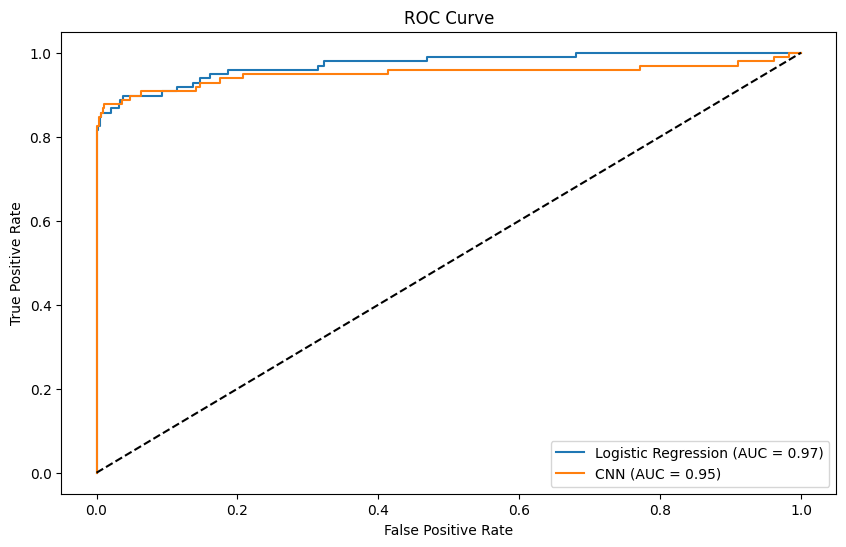

In [ ]:
# 데이터를 2차원으로 변환
original_Xtrain_2d = original_Xtrain.reshape(original_Xtrain.shape[0], -1)
original_Xtest_2d = original_Xtest.reshape(original_Xtest.shape[0], -1)

# Logistic Regression 모델 훈련 및 예측
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(original_Xtrain_2d, original_ytrain)
log_reg_pred_prob = log_reg.predict_proba(original_Xtest_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(original_ytest, log_reg_pred_prob)

# CNN 모델의 예측 확률 계산 및 ROC 곡선 구성
cnn_pred_prob = model1.predict(original_Xtest).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(original_ytest, cnn_pred_prob)


# AUC 계산
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)
cnn_auc = auc(cnn_fpr, cnn_tpr)

# ROC 곡선 그리기 및 AUC 표시
plt.figure(figsize=(10, 6))
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {cnn_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 대각선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Cluster
146884,-0.293579,0.038170,2.054361,-0.122642,-1.245717,0.189567,0.132497,-0.620765,0.059581,-0.148058,...,-0.271204,-0.687048,0.271569,-0.497120,-0.270115,0.208619,-0.076075,-0.075428,0,1
95597,18.615944,-0.226824,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,...,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1,0
96768,1.872424,-0.220456,0.955253,-0.833374,0.847147,0.725970,-1.322868,-0.238842,-0.565347,0.022443,...,-0.110554,-0.129397,-0.040892,0.364872,0.204756,-0.304578,0.055908,0.062489,0,0
75511,2.080905,-0.335930,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,...,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,1,0
255556,-0.296653,0.852830,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,...,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,1,1


Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


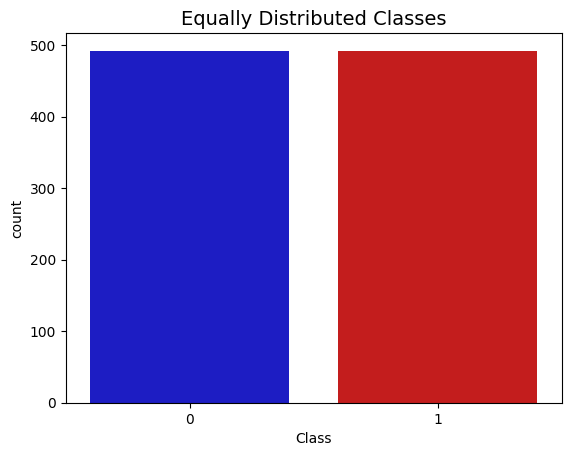

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 14, 1)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 14, 32)            128       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 7, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 7, 64)             6208      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 192)               0   

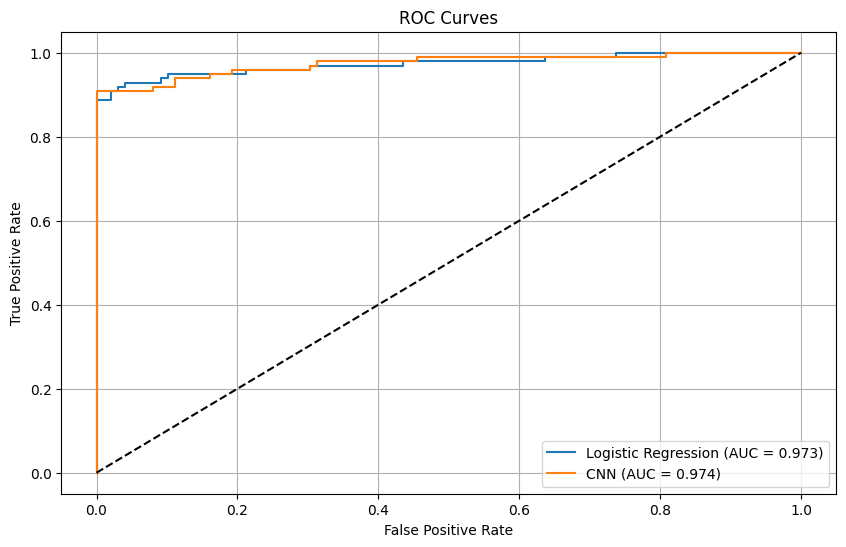

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# 데이터 선택 및 분할
selected_columns = ['V1', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V18', 'scaled_time']
X = new_df[selected_columns]
y = new_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터를 2차원으로 변환
X_train_2d = X_train.values.reshape(X_train.shape[0], -1)
X_test_2d = X_test.values.reshape(X_test.shape[0], -1)

# Logistic Regression 모델 훈련 및 예측
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_2d, y_train)
log_reg_pred_prob = log_reg.predict_proba(X_test_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_prob)

# CNN 모델 구성, 훈련 및 예측
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)
input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)

x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)

x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

cnn_pred_prob = model.predict(X_test).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred_prob)

# ROC 곡선 시각화 함수 정의 및 실행
def plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr):
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_reg_pred_prob):.3f})')
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {roc_auc_score(y_test, cnn_pred_prob):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr)

7/7 [==============================] - 0s 2ms/step


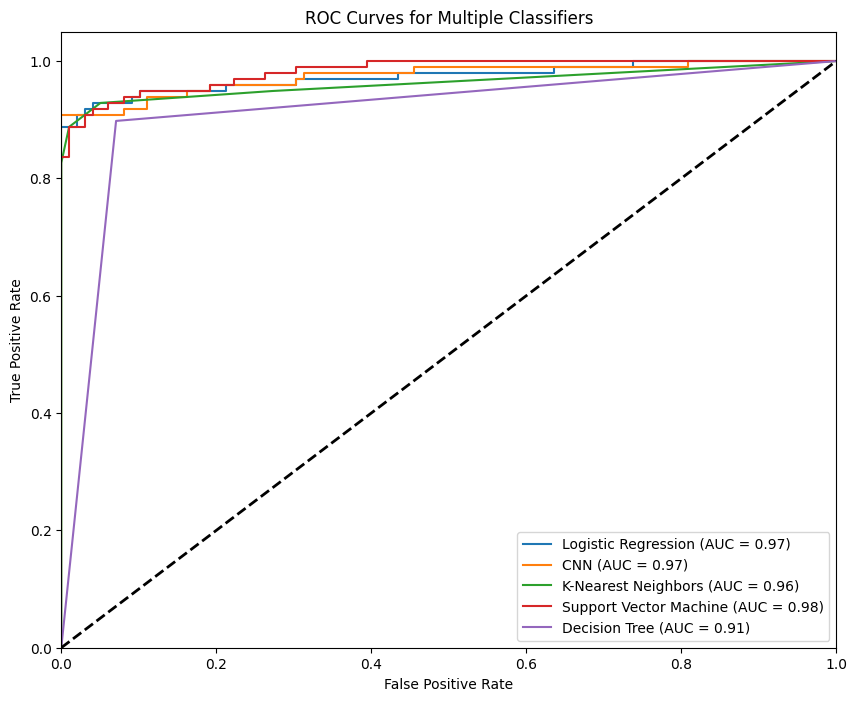

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 데이터를 2차원으로 변환
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Logistic Regression 모델 훈련 및 예측
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_2d, y_train)
log_reg_pred_prob = log_reg.predict_proba(X_test_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_prob)

# CNN 모델의 예측 확률 계산 및 ROC 곡선 구성
cnn_pred_prob = model.predict(X_test).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred_prob)

# K-최근접 이웃 모델 훈련 및 예측
knears = KNeighborsClassifier()
knears.fit(X_train_2d, y_train)
knears_pred = knears.predict_proba(X_test_2d)[:, 1]
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, knears_pred)

# SVC 모델 훈련 및 예측
svc = SVC(probability=True)
svc.fit(X_train_2d, y_train)
svc_pred = svc.predict_proba(X_test_2d)[:, 1]
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)

# 결정 트리 모델 훈련 및 예측
tree = DecisionTreeClassifier()
tree.fit(X_train_2d, y_train)
tree_pred = tree.predict_proba(X_test_2d)[:, 1]
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred)

# ROC 곡선 시각화
plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)


In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# 각 분류기에 대한 예측
log_reg_pred = log_reg.predict(X_test_2d)
knears_pred = knears.predict(X_test_2d)
svc_pred = svc.predict(X_test_2d)
tree_pred = tree.predict(X_test_2d)

# 모델 성능 평가 및 출력
models = [('Logistic Regression', log_reg_pred), ('K-Nearest Neighbors', knears_pred),
          ('SVC', svc_pred), ('Decision Tree', tree_pred)]
for model_name, y_pred in models:
    print('---' * 25)
    print(f'{model_name} - Test Set Evaluation:\n')
    print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('---' * 25)

# 샘플 데이터의 평균 성능 지표 (여기서는 임의의 값으로 설정, 실제 데이터에 맞게 조정 필요)
undersample_accuracy = [0.95]  # 예시 값
undersample_precision = [0.97]
undersample_recall = [0.93]
undersample_f1 = [0.95]

print('---' * 25)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 25)


---------------------------------------------------------------------------
Logistic Regression - Test Set Evaluation:

Recall Score: 0.89
Precision Score: 1.00
F1 Score: 0.94
Accuracy Score: 0.94
---------------------------------------------------------------------------
---------------------------------------------------------------------------
K-Nearest Neighbors - Test Set Evaluation:

Recall Score: 0.89
Precision Score: 0.99
F1 Score: 0.94
Accuracy Score: 0.94
---------------------------------------------------------------------------
---------------------------------------------------------------------------
SVC - Test Set Evaluation:

Recall Score: 0.84
Precision Score: 0.99
F1 Score: 0.91
Accuracy Score: 0.91
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Decision Tree - Test Set Evaluation:

Recall Score: 0.90
Precision Score: 0.93
F1 Score: 0.91
Accuracy Score: 0.91
------

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=42)

# 데이터 분할 (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE 적용 (Over-sampling)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# NearMiss 적용 (Under-sampling)
nearmiss = NearMiss()
X_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)

# 로지스틱 회귀 모델 훈련 및 평가 (SMOTE 데이터 사용)
model_smote = LogisticRegression()
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)
print("SMOTE 적용 데이터의 분류 결과:")
print(classification_report(y_test, y_pred_smote))

# 로지스틱 회귀 모델 훈련 및 평가 (NearMiss 데이터 사용)
model_nearmiss = LogisticRegression()
model_nearmiss.fit(X_train_nearmiss, y_train_nearmiss)
y_pred_nearmiss = model_nearmiss.predict(X_test)
print("NearMiss 적용 데이터의 분류 결과:")
print(classification_report(y_test, y_pred_nearmiss))

SMOTE 적용 데이터의 분류 결과:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       299
           1       1.00      1.00      1.00         1

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

NearMiss 적용 데이터의 분류 결과:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       299
           1       0.25      1.00      0.40         1

    accuracy                           0.99       300
   macro avg       0.62      0.99      0.70       300
weighted avg       1.00      0.99      0.99       300



In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Model

# CNN 모델을 생성하는 함수 정의
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 입력 형태 설정
input_shape = (X_train.shape[1], 1)

# SMOTE 및 NearMiss 데이터에 대한 CNN 모델 생성
model_cnn_smote = create_cnn_model(input_shape)
model_cnn_nearmiss = create_cnn_model(input_shape)

# 모델 훈련
history_smote = model_cnn_smote.fit(X_train_smote, y_train_smote, epochs=5, batch_size=32, validation_data=(X_test, y_test))
history_nearmiss = model_cnn_nearmiss.fit(X_train_nearmiss, y_train_nearmiss, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# 정확도 평가
_, accuracy_smote = model_cnn_smote.evaluate(X_test, y_test)
_, accuracy_nearmiss = model_cnn_nearmiss.evaluate(X_test, y_test)

print(f"CNN + SMOTE 데이터의 정확도: {accuracy_smote:.2f}")
print(f"CNN + NearMiss 데이터의 정확도: {accuracy_nearmiss:.2f}")


Epoch 1/10
44/44 [==============================] - 2s 16ms/step - loss: 0.3319 - accuracy: 0.9465 - val_loss: 0.0944 - val_accuracy: 0.9667
Epoch 2/10
44/44 [==============================] - 0s 5ms/step - loss: 0.0384 - accuracy: 0.9935 - val_loss: 0.0375 - val_accuracy: 0.9833
Epoch 3/10
44/44 [==============================] - 0s 5ms/step - loss: 0.0136 - accuracy: 0.9978 - val_loss: 0.0513 - val_accuracy: 0.9833
Epoch 4/10
44/44 [==============================] - 0s 4ms/step - loss: 0.0086 - accuracy: 0.9986 - val_loss: 0.0140 - val_accuracy: 0.9933
Epoch 5/10
44/44 [==============================] - 0s 4ms/step - loss: 0.0061 - accuracy: 0.9993 - val_loss: 0.0198 - val_accuracy: 0.9933
Epoch 6/10
44/44 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9933
Epoch 7/10
44/44 [==============================] - 0s 5ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9967
Epoch 8/10
44/44 [=

10/10 [==============================] - 0s 2ms/step


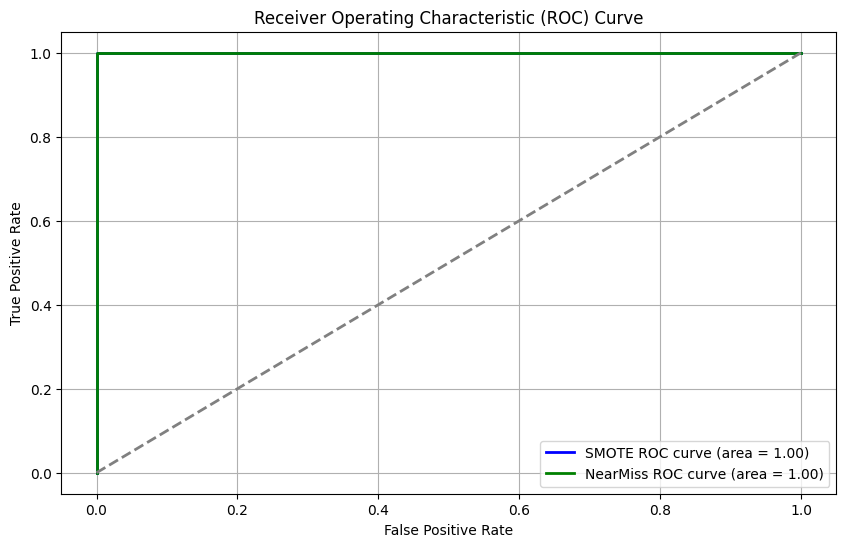

In [ ]:
# SMOTE 데이터에 대한 모델의 ROC 곡선 그리기
y_prob_smote = model.predict(X_test).ravel()
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_prob_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)

# NearMiss 데이터에 대한 모델의 ROC 곡선 그리기
y_prob_nearmiss = model.predict(X_test).ravel()
fpr_nearmiss, tpr_nearmiss, _ = roc_curve(y_test, y_prob_nearmiss)
roc_auc_nearmiss = auc(fpr_nearmiss, tpr_nearmiss)

# ROC 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(fpr_smote, tpr_smote, color='blue', lw=2, label=f'SMOTE ROC curve (area = {roc_auc_smote:.2f})')
plt.plot(fpr_nearmiss, tpr_nearmiss, color='green', lw=2, label=f'NearMiss ROC curve (area = {roc_auc_nearmiss:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 모델 초기화
model = RandomForestClassifier()

# Stratified K-Fold 교차 검증기 생성
# StratifiedKFold는 각 폴드 내 클래스 비율을 원본 데이터셋의 클래스 비율과 동일하게 유지합니다.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
scores = cross_val_score(model_smote, X, y, cv=skf, scoring='accuracy')

print(f'교차 검증 정확도: {scores}')
print(f'평균 정확도: {scores.mean()}')

# 모델 초기화
model = RandomForestClassifier()

# Stratified K-Fold 교차 검증기 생성
# StratifiedKFold는 각 폴드 내 클래스 비율을 원본 데이터셋의 클래스 비율과 동일하게 유지합니다.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
scores = cross_val_score(model_nearmiss, X, y, cv=skf, scoring='accuracy')

print(f'교차 검증 정확도: {scores}')
print(f'평균 정확도: {scores.mean()}')

교차 검증 정확도: [0.995 1.    0.995 0.995 0.995]
평균 정확도: 0.9960000000000001
교차 검증 정확도: [0.995 1.    0.995 0.995 0.995]
평균 정확도: 0.9960000000000001


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

# 모델 초기화
model = RandomForestClassifier()

# Repeated Stratified K-Fold 교차 검증기 생성
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# 교차 검증 수행
scores = cross_val_score(model_smote, X, y, cv=rskf, scoring='accuracy')

print(f'교차 검증 정확도: {scores}')
print(f'평균 정확도: {scores.mean()}')

# 모델 초기화
model = RandomForestClassifier()

# Repeated Stratified K-Fold 교차 검증기 생성
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# 교차 검증 수행
scores = cross_val_score(model_nearmiss, X, y, cv=rskf, scoring='accuracy')

print(f'교차 검증 정확도: {scores}')
print(f'평균 정확도: {scores.mean()}')

교차 검증 정확도: [0.995 1.    0.995 0.995 0.995 1.    0.995 0.995 0.995 0.995 0.995 0.995
 1.    0.99  1.   ]
평균 정확도: 0.9959999999999999
교차 검증 정확도: [0.995 1.    0.995 0.995 0.995 1.    0.995 0.995 0.995 0.995 0.995 0.995
 1.    0.99  1.   ]
평균 정확도: 0.9959999999999999


In [ ]:
from sklearn.model_selection import LeaveOneOut

# 모델 초기화
model = RandomForestClassifier()

# Leave-One-Out 교차 검증기 생성
loo = LeaveOneOut()

# 교차 검증 수행
scores = cross_val_score(model_nearmiss, X, y, cv=loo, scoring='accuracy')

print(f'교차 검증 정확도: {scores}')
print(f'평균 정확도: {scores.mean()}')

교차 검증 정확도: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Stratified K-Fold 교차 검증
model = RandomForestClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_skf = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
df_skf = pd.DataFrame({
    'Fold': range(1, len(scores_skf) + 1),
    'Accuracy': scores_skf
})
df_skf.loc['Mean'] = ['Mean', scores_skf.mean()]

# Repeated Stratified K-Fold 교차 검증
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores_rskf = cross_val_score(model, X, y, cv=rskf, scoring='accuracy')
df_rskf = pd.DataFrame({
    'Fold': range(1, len(scores_rskf) + 1),
    'Accuracy': scores_rskf
})
df_rskf.loc['Mean'] = ['Mean', scores_rskf.mean()]

# Leave-One-Out 교차 검증
loo = LeaveOneOut()
scores_loo = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
df_loo = pd.DataFrame({
    'Fold': range(1, len(scores_loo) + 1),
    'Accuracy': scores_loo
})
df_loo.loc['Mean'] = ['Mean', scores_loo.mean()]

# 결과 출력
print("\nStratified K-Fold Results:\n", df_skf)
print("\nRepeated Stratified K-Fold Results:\n", df_rskf)
print("\nLeave-One-Out Results:\n", df_loo)



Stratified K-Fold Results:
       Fold  Accuracy
0        1     1.000
1        2     1.000
2        3     1.000
3        4     1.000
4        5     0.995
Mean  Mean     0.999

Repeated Stratified K-Fold Results:
       Fold  Accuracy
0        1  1.000000
1        2  1.000000
2        3  1.000000
3        4  1.000000
4        5  0.995000
5        6  1.000000
6        7  1.000000
7        8  0.995000
8        9  1.000000
9       10  1.000000
10      11  0.995000
11      12  0.995000
12      13  1.000000
13      14  1.000000
14      15  1.000000
Mean  Mean  0.998667

Leave-One-Out Results:
       Fold  Accuracy
0        1     1.000
1        2     1.000
2        3     1.000
3        4     1.000
4        5     1.000
...    ...       ...
996    997     1.000
997    998     1.000
998    999     1.000
999   1000     1.000
Mean  Mean     0.998

[1001 rows x 2 columns]
